In [1]:
"""
OIII5007 Double Gaussian Modelling z bin 1

Author: Alan Nguyen

01-06-2020
"""

'\nOIII5007 Double Gaussian Modelling z bin 1\n\nAuthor: Alan Nguyen\n\n01-06-2020\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v7 import *
from general_functions_v1 import *

In [3]:
hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin1_v2.fits')

zbin1_data = hdul[1].data

hdul.close()

In [4]:
specs ={}
count = 0

for row in zbin1_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin1_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin1_data)), end = "") #progress bar to keep track of progress

Complete: 29/820

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 820/820

In [5]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs: #for every spectrum generated in previous block
    wave = specs[key][0] #extract wavelength array
    fluxden = specs[key][1] #extract flux density array
    k = specs[key][2] #z + 1, to account for redshift during the trimming
    error = specs[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs.pop(key, None)

Complete: 481/820

Complete: 820/820

In [6]:
preset_parameters = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
TRIALS = 100 #set number of trials for the Monte-Carlo error
MC_flags = np.zeros((TRIALS, len(trimmed_specs)))
count = 0
final_results = {}
start_time = time.process_time()

for key in trimmed_specs: #loop and use the fit on all the trimmed specs
    
    used_preset = False #by default use the generic initial conditions

    OIII_wave    = trimmed_specs[key][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[key][1] #array with corresponding flux density values
    k            = trimmed_specs[key][2] #corresponding z + 1 value
    OIII_error   = trimmed_specs[key][3] #array with corresponding flux density error values
    
    ###############################
    ###############################
    
    specific_presets = {} #prepare a dictionary with velocity means corrected for the current spectrum's k value

    for p in preset_parameters: #for every key in the preset parameters
        
    ###############################
    ###############################
        
        k_corrected_parameters = preset_parameters[p][0] #take the parameters first 
        
    ###############################
    
#     Using z = v / c
    
#     z1 / v1 = c = z2 / v2
    
#     v2 = (z2 / z1) * v1
    
#     z2 = k_spectrum - 1

#     z1 = k_fit - 1
    
    ###############################
        
        k_corrected_parameters[1] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[1]
        k_corrected_parameters[4] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[4]
        
    ###############################
#   
    
#     Sometimes get a problem with the above
    
#   
    ###############################
        
        #if the angstrom value of the mean is not within the wavelength range, then bring it back into the range for both means
        if to_angstrom_OIII(k_corrected_parameters[1]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[1]) <= OIII_wave[0]:
            k_corrected_parameters[1] = (k - 1) * 300000
         
        if to_angstrom_OIII(k_corrected_parameters[4]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[4]) <= OIII_wave[0]:
            k_corrected_parameters[4] = (k - 1) * 300000
            
        #if it turns out that both are not in the range, make generic velocity means and keep widths and amplitudes
        if k_corrected_parameters[1] == k_corrected_parameters[4]:
            k_corrected_parameters[1] = to_vel_OIII(5007*k)
            k_corrected_parameters[4] = identify_wing(OIII_wave, OIII_fluxden, k)
        
        specific_presets.update({p:k_corrected_parameters}) #update the specific presets dictionary with the k corrected velocity means
    
    if len(preset_parameters) == 0: #this is for the first iteration
        similarity_table = np.zeros(shape = (1, 9)) #make a single row with [0] the rcsq, [1:8] parameters, filled with zeros
        similarity_table[0][0] = np.inf #set the rcsq value to infinity to force generic parameters because there are no presets to try
        
    else:
        similarity_table = np.zeros(shape = (len(preset_parameters), 9)) #create empty array to store rcsq and parameters used to generate them
    
    ###############################
    ###############################
    
    #generate initial parameters
    
    ###############################
    ###############################
    
    double_gaussian_parameters = double_gauss_params(OIII_wave, OIII_fluxden, k) #generate generic parameters
    
    parameters_counter = 0 #used to loop down the similarity table
    
    for p in specific_presets: #try to see if can get better starting parameters from the previously done spectra
        
        similarity1 = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, specific_presets[p])) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
                                        
        similarity_table[parameters_counter][0] = similarity2 #parameters_counter gives row, first entry is the similiarity2, rcsq for the current parameters being tested
        similarity_table[parameters_counter][1::] = specific_presets[p] #set the rest of the row to the parameters used to generate the similarity2, rcsq
        parameters_counter += 1

    best_rcsq = np.min(similarity_table[:,0]) #identify the lowest value in the first column, the best rcsq
    
    ###############################
    ###############################
    
    initial_conditions = np.zeros(shape = (1, 8)) #make an empty array with enough space to hold the 8 parameters
    
    ###############################
    ###############################
    
    try: #will almost always use this
        if best_rcsq <= 20: #arbitrary guess, seems to give lowest average rcsq

            used_preset = True #note that a preset was used, do not update the dictionary with this fit
            
            initial_conditions = similarity_table[np.where(similarity_table[:,0] == best_rcsq)][0][1::] #find the row corresponding to the lowest rcsq value and set the initial conditions to those parameters

        else:
            initial_conditions = double_gaussian_parameters #if the best rcsq isn't lower than 40 (again, arbitrary guess) then force the generic parameters
    
    except: #iterations with a 0 length preset parameters may run into an error, force generic parameters in that case
        initial_conditions = double_gaussian_parameters
    
    ###############################
    ###############################

    MC_params = np.zeros((TRIALS, 9))
    
    ###############################
    ###############################ERROR IN PARAMETERS
    
    results = []
    
    for r in range(TRIALS): #create a fit for every row of MC_params, number of TRIALS
        iter_dat = np.random.normal(OIII_fluxden, OIII_error) #fluctuate the data using the given error
        iter_dat = iter_dat.astype('float32') #change data type so it works lol

        fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, iter_dat, OIII_error), maxfev = 100000) #fit the iteration data using the same initial parameters
        MC_params[r][0:8] = fit_params[0] #set the first 8 columns with the parameters
        iter_flag = flag_spec(fit_params, OIII_wave, iter_dat, OIII_error) #flag the iteration fit
        MC_params[r][8] = iter_flag #give the 9th column the iteration flag
        
    for i in range(8): #now loop over the first 8 columns
        results.append(np.mean(MC_params[:,i]))
        results.append(np.std(MC_params[:,i]))
    
    final_params = np.array(results)
    #0 amplitude1               8 velocity_mean2
    #1 amplitude1_error         9 velocity_mean2_error
    #2 velocity_mean1          10 velocity_width2
    #3 velocity_mean1_error    11 velocity_width2_error
    #4 velocity_width1         12 linear_slope
    #5 velocity_width1_error   13 linear_slope_error
    #6 amplitude2              14 linear_yintercept
    #7 amplitude2_error        15 linear_yintercept_error
    
    final_results.update({key:final_params})
    MC_flags[:,count] = MC_params[:,8]
    
#     final_params = np.array([final_params[0::2], 0])
#     final_flag = flag_spec(final_params, OIII_wave, OIII_fluxden, OIII_error)
    
    ###############################
    ###############################
    
    fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, OIII_fluxden, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
    
    params = fit_params[0] #take only the parameters
     
#     fit = double_gaussian_lincont(OIII_wave, params) #generate y values for the fit
    
#     csq = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, params)) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
#     rcsq = csq / len(OIII_fluxden) #divide by length for reduced chi squared
    
    ###############################
    ###############################
    
    if used_preset == False: #if a preset was not used, then update a new preset in the dictionary with this fit
        preset_parameters.update({key:[params, k]}) #0 fit parameters, 1 k value
    
    count += 1
    print("\r" + "Complete: {}".format(count), end = "")
    
print(" ")
print("Runtime: {}s".format((time.process_time() - start_time)))
    


Complete: 167

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 100000.
  warnings.warn(errors[info][0], RuntimeWarning)


Complete: 820 
Runtime: 1401.890625s


In [7]:
sum1 = 0
flags = []
for key in trimmed_specs:
    wave = trimmed_specs[key][0]
    fluxden = trimmed_specs[key][1]
    model = final_results[key][0::2]
    error = trimmed_specs[key][3]
    
    component1 = final_results[key][0:6]
    component2 = final_results[key][6:12]
    
    component1 = component1[0::2]
    component2 = component2[0::2]
    

    
    similarity1 = np.sum(((fluxden - double_gaussian_lincont(wave, model)) / error) ** 2) #take csq between current data in iteration and fits from preset
    similarity2 = similarity1 / len(fluxden) #divide by length for reduced chi squared
    
#     sum1 += similarity2
    
#     plt.plot(wave, fluxden, 'k')
#     plt.plot(wave, double_gaussian_lincont(wave, model), 'r--')
#     plt.plot(wave, gaussian(wave, component1), 'g--')
#     plt.plot(wave, gaussian(wave, component2), 'b--')
#     plt.plot(wave, error, 'm:')
    
#     plt.show()
#     plt.clf()
    
    flag = flag_spec(np.array([model]), wave, fluxden, error)
    print(flag)
    print(similarity2)
    print(component1, component2)
    
    flags.append(flag)


2
3.8709826802098473
[5.85918941e-01 1.27222891e+04 3.22781217e+02] [3.27695269e-01 1.26454551e+04 6.79158662e+02]
2
0.6375021934509277
[1.86979268e-01 2.22032335e+04 4.20258608e+02] [1.48045563e-01 2.16999394e+04 9.33663666e+02]
3
2.8675751796988553
[6.55327855e-01 2.00974442e+04 2.30866409e+02] [1.95081846e-01 2.01219526e+04 5.64573772e+02]
3
2.1135642473087755
[6.57116367e-01 2.00972914e+04 2.28026661e+02] [1.98182316e-01 2.01542445e+04 5.51221714e+02]
3
1.3420198130053143
[6.74594310e-01 2.01059743e+04 2.48588022e+02] [1.81182382e-01 2.01593549e+04 6.08598932e+02]
3
1.5647545747978742
[6.22576710e-01 2.01011604e+04 2.41186403e+02] [2.26507811e-01 2.01665707e+04 5.59554902e+02]
2
1.5974550468977107
[6.77241750e-01 2.00995189e+04 2.56699445e+02] [1.43153734e-01 2.00981337e+04 6.55759651e+02]
3
1.4542969991994459
[6.49914597e-01 2.00985779e+04 2.51767119e+02] [1.71441181e-01 2.01401944e+04 6.14910723e+02]
2
2.643861637559048
[1.19121224e-01 3.93758220e+04 2.31357930e+02] [1.79802232e-

[6.55378249e-01 2.04829065e+04 3.97539004e+02] [6.98064853e-02 2.01901436e+04 8.83602627e+02]
3
1.0822637731378728
[3.26742660e-01 4.08202154e+04 3.77504039e+02] [2.65783610e-01 4.10643711e+04 1.18592985e+03]
1
1.4850891468136809
[1.95099357e-01 4.12296212e+04 4.97797361e+02] [ 1.30913704e+00  3.99671352e+04 -1.36377930e+04]
0
5.5848608682321945
[1.71706889e-01 4.15549112e+04 6.65146500e+02] [-2.70879489e-01  4.21657468e+04 -3.60923174e+02]
1
10.208911274754724
[2.01140135e-01 1.83991929e+04 1.94330177e+02] [4.05607924e-01 1.78531617e+04 2.34060902e+03]
0
10329.88565340909
[-5.15950479e+00  3.16017824e+04  2.71136132e+02] [5.97887149e+00 3.14677663e+04 3.48290405e+02]
0
3.3832633278586646
[-2.76360039e-02  3.25394760e+04  4.08608705e+01] [2.27041065e-01 3.26649651e+04 2.10586482e+02]
0
39.23506200036337
[8.00405327e-01 2.32887684e+04 2.84244852e+02] [-3.91818647e-01  2.33810937e+04  1.53339605e+03]
0
4.22113037109375
[ 4.27327656e-02  3.39947369e+04 -3.57803511e+02] [-5.58081792e-03  3

0
4.833895943381569
[-1.21611655e-02  3.33756065e+04  5.14445968e+01] [1.71118117e-01 3.36350912e+04 1.08053585e+03]
2
0.9097102772105824
[5.63678836e-01 2.56606335e+04 3.56918682e+02] [9.79000837e-02 2.51828549e+04 8.45178440e+02]
0
114.4488894440407
[2.61580352e-01 1.63307692e+04 3.27128402e+02] [5.49765756e-01 1.61389132e+04 6.14573731e+02]
2
7.463643628497456
[1.81510030e-01 1.29884800e+04 3.73286299e+02] [1.78477188e-01 1.24447930e+04 8.77673791e+02]
3
0.905122930353338
[2.53408125e-01 2.02461432e+04 3.78474418e+02] [5.12312709e-01 2.01203980e+04 2.37856992e+02]
2
2.1357379292332848
[2.91953555e-01 4.25019692e+04 3.36663405e+01] [2.49389827e-01 4.24756192e+04 9.88459739e+02]
2
1.116518774697947
[6.86902552e-01 3.18484519e+04 2.11369565e+02] [3.24867374e-01 3.17904839e+04 2.92170603e+02]
2
0.8588216027548147
[5.36390007e-01 3.80808467e+04 3.52732818e+02] [3.05158364e-01 3.78459766e+04 8.71998785e+02]
3
1.194921804028888
[7.06406438e-01 4.13186963e+04 2.41710111e+02] [3.09820421e-01

In [8]:
flags = np.array(flags) #convert the list into an array for faster processing
unique, counts = np.unique(flags, return_counts=True) #count occurences of each flag
ye = dict(zip(unique, counts)) #put into dictionary
print(ye) #print the dictionary to view the wing values

{0: 387, 1: 58, 2: 270, 3: 105}


In [20]:
len(preset_parameters)

178

In [11]:
percents = np.zeros((TRIALS, 4))
r_num = 0
for r in MC_flags:
    flag, counts = np.unique(r, return_counts = True) #count occurences of each flag
    
    temp_percents = (counts * 100) / len(r)
    
    percents[r_num] = temp_percents
    
    r_num += 1
    
bad_data_mean = np.mean(percents[:,0])
bad_data_std = np.std(percents[:,0])

no_outflow_mean = np.mean(percents[:,1])
no_outflow_std = np.std(percents[:,1])

blu_wing_mean = np.mean(percents[:,2])
blu_wing_std = np.std(percents[:,2])

red_wing_mean = np.mean(percents[:,3])
red_wind_std = np.std(percents[:,3])

print('Outflow Percentages z bin 1')
print('\n')

print('BadDataMean: {:.2f}'.format(bad_data_mean))
print('BadDataErr: {:.2f}'.format(bad_data_std))
print('\n')

print('NoOutflowMean: {:.2f}'.format(no_outflow_mean))
print('NoOutflowErr: {:.2f}'.format(no_outflow_std))
print('\n')

print('BlueWingMean: {:.2f}'.format(blu_wing_mean))
print('BlueWingErr: {:.2f}'.format(blu_wing_std))
print('\n')

print('RedWingMean: {:.2f}'.format(red_wing_mean))
print('RedWingErr: {:.2f}'.format(red_wind_std))
print('\n')

Outflow Percentages z bin 1


BadDataMean: 30.54
BadDataErr: 1.40


NoOutflowMean: 15.34
NoOutflowErr: 1.18


BlueWingMean: 35.44
BlueWingErr: 1.13


RedWingMean: 18.69
RedWingErr: 1.05




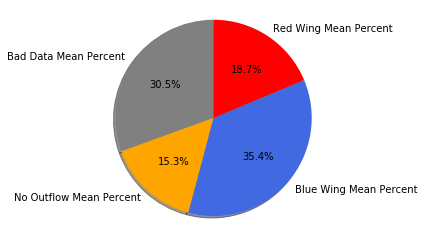

In [12]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Bad Data Mean Percent', 'No Outflow Mean Percent', 'Blue Wing Mean Percent', 'Red Wing Mean Percent'
sizes = [bad_data_mean, no_outflow_mean, blu_wing_mean, red_wing_mean]

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ('grey', 'orange', 'royalblue', 'red'))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.savefig('classification_pie_zbin1.png')

plt.show()

In [40]:
to_vel_OIII(5380) - to_vel_OIII(5348)

1917.3157579388862